In [21]:
import torch

import commons
import utils
from models import SynthesizerTrn
from text.symbols import symbols
from text import text_to_sequence
import random
from pathlib import Path
import librosa

from IPython.display import Audio
import matplotlib.pyplot as plt

In [15]:
def get_text(text, hps):
    text_norm = text_to_sequence(text, hps.data.text_cleaners)
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm

def load_data(path):
    au, sr = librosa.load(path)
    embed_ref = torch.load(path.replace(".wav", ".emb.pt").replace("dataset", "embed"), "cpu")
    return au, sr, embed_ref.unsqueeze(0)

def choose_ref():
    # choose a person
    spkr_id = random.choice(keys)
    
    # choose a path
    path = random.choice(spkr_dict[spkr_id])
    path = "../data/dataset/" + path
    
    # load data
    return load_data(path)

In [3]:
with open("./filelists/my_val_filelist.txt.cleaned", "r") as f:
    data = f.readlines()
data = [line.split("|")[:2] for line in data]

In [4]:
spkr_dict = {}
for path, id in data:
    if id not in spkr_dict:
        spkr_dict[id] = [path]
    else:
        spkr_dict[id].append(path)

In [5]:
keys = list(spkr_dict.keys())

In [44]:
hps = utils.get_hparams_from_file("./configs/my_base.json")
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model).cpu()
net_g.eval()

utils.load_checkpoint("../checkpoints/exp1/last_gen.pth", net_g, None)

INFO:root:Loaded checkpoint '../checkpoints/exp1/last_gen.pth' (iteration 1200)


(SynthesizerTrn(
   (enc_p): TextEncoder(
     (emb): Embedding(192, 192)
     (encoder): Encoder(
       (drop): Dropout(p=0.1, inplace=False)
       (attn_layers): ModuleList(
         (0): MultiHeadAttention(
           (conv_q): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_k): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_v): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_o): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (drop): Dropout(p=0.1, inplace=False)
         )
         (1): MultiHeadAttention(
           (conv_q): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_k): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_v): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_o): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (drop): Dropout(p=0.1, inplace=False)
         )
         (2): MultiHeadAttention(
           (conv_q): Conv1d(192, 192, kernel_siz

In [45]:
real_au, sr, embed_ref = load_data("../data/dataset/VIVO/VIVOSSPK01_R002.wav")

In [56]:
text = "chỉ bằng cách luôn nỗ lực thì cuối cùng bạn mới được đền đáp"
stn_tst = get_text(text, hps)
with torch.no_grad():
    x_tst = stn_tst.cpu().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cpu()
    # o = net_g.infer(x_tst, x_tst_lengths, embed_ref, noise_scale=.5, noise_scale_w=0.5, length_scale=1)
    fake_au = net_g.infer(x_tst, x_tst_lengths, embed_ref, noise_scale=.5, noise_scale_w=0.5, length_scale=1)[0][0,0].data.cpu().float().numpy()

Text(0.5, 1.0, 'Fake Audio')

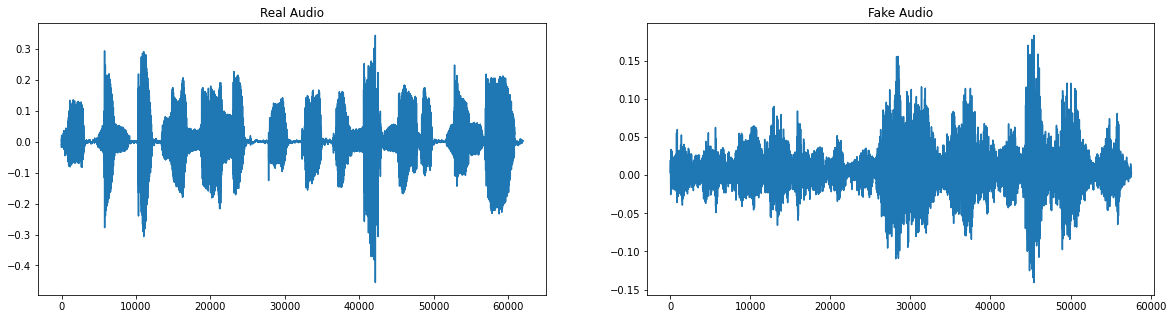

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(real_au)
ax[0].set_title("Real Audio")
ax[1].plot(fake_au)
ax[1].set_title("Fake Audio")

In [59]:
# real voice
Audio(data=real_au, rate=sr)

In [60]:
# gnerated voice
Audio(data=fake_au, rate=sr)